<a href="https://colab.research.google.com/github/PingPingE/Learn_ML_DL/blob/main/Decision_Tree/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree

- 데이터들이 가진 속성들로부터 분할 기준 속성을 판별하고, 분할 기준 속성에 따라 트리 형태로 모델링하는 분류 예측 모델
- 분할 기준 설정: 부모노드(현재 노드)에 비해 자식 노드의 불순도가 감소되도록 설정한다.
- 현재 노드의 불순도와 자식 노드의 불순도 차이가 최대가 되는 기준을 찾는다.
<br>

### 장점
- 과정 이해 및 해석하기 쉽다.
- 전처리 부담을 줄여준다.(스케일링 등의 작업이 무의미)
- 대용량 데이터에서도 빠르게 만들 수 있다.
- 수치형과 범주형 모두 다룰 수 있다.
<br>

### 단점
- 연속형 변수를 비연속적인 값으로 취급하므로 분리의 경계점 근방에서 예측 오류가 클 가능성이 있다.
- 선형 관계를 다루지 못한다. 
- input 데이터에만 의존해서 과적합의 위험성이 높다.(너무 데이터가 적거나 피처가 너무 많거나, 데이터가 불균형하거나 등의 경우 X) -> 앙상블, 차원 축소 등으로 완화하자.

<br>

### 의사결정나무의 분석 과정
1. <strong>의사결정 나무 성장(Growing)</strong>: 분석의 목적과 자료구조에 따라 적절한 분리 규칙(Splitting Rule)을 찾아서 나무를 성장 시킨다(Stopping Rule을 만족하면 중단)
- 재귀적으로 수행(분리하고 거기서 또 분리하고...)
- 분리 기준: 입력 변수의 선택 + 범주 선정


2. <strong>가지치기(Pruning)</strong>: 분류 오류(Classification Error)를 크게 할 위함(Risk)이 높거나 부적절한 추론규칙을 갖고 있는 가지(Branch) 또는 불필요한 가지를 제거한다.

3. <strong>타당성 평가</strong>: 이익 도표(Gain chart), 위험 도표(Risk chart)를 이용해서 Cross validation 등을 이용한 평가 수행

4. <strong>해석 및 예측</strong>: 구축된 의사결정나무 모형을 해석하고, 분류 및 예측 모형을 설정하여 데이터의 분류 및 예측에 활용한다.


참고)
- [scikit-learn](https://scikit-learn.org/stable/modules/tree.html)
- [scikit-learn github](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/tree/_tree.pyx)
- [youtube-StatQuest](https://www.youtube.com/watch?v=7VeUPuFGJHk)
- 수제비
- 핸즈온 머신러닝

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston

## Classification

In [ ]:
X,y=load_iris(return_X_y=True)
clf=tree.DecisionTreeClassifier()
clf=clf.fit(X,y)

In [ ]:
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
X.shape

(150, 4)

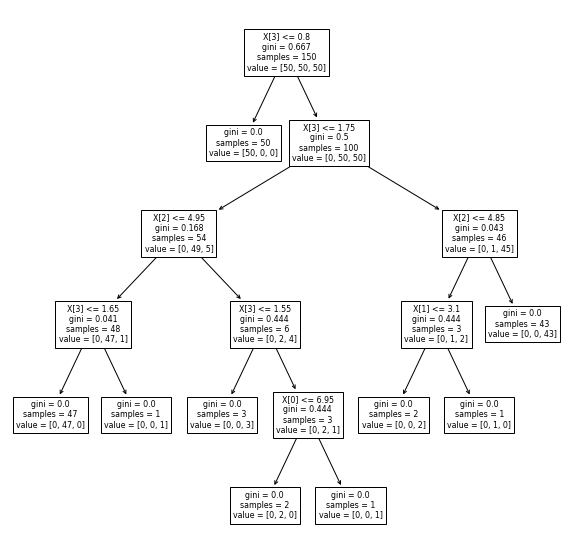

In [ ]:
plt.figure(figsize=(10,10))
tree.plot_tree(clf)
plt.show()

## Regression

In [ ]:
X_2,y_2=load_boston(return_X_y=True)
reg=tree.DecisionTreeRegressor(max_depth=3) #깊어서 보기 힘듦...
reg=reg.fit(X_2,y_2)

In [ ]:
reg

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
X_2.shape

(506, 13)

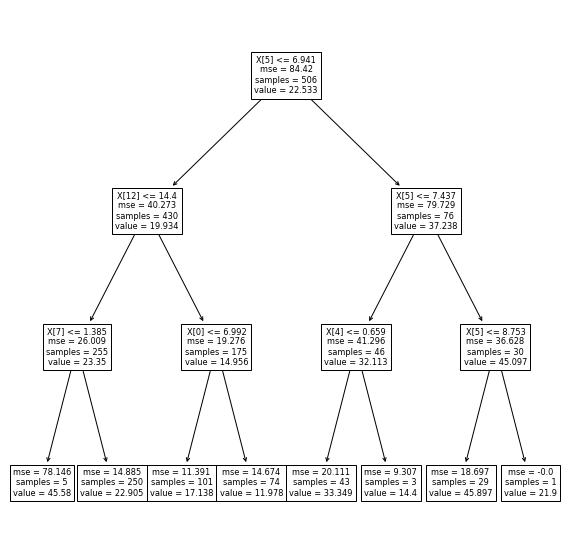

In [ ]:
plt.figure(figsize=(10,10))
tree.plot_tree(reg)
plt.show()

## 의사결정나무의 구성요소

In [ ]:
cdef struct Node:
    # Base storage structure for the nodes in a Tree object

    SIZE_t left_child                    # id of the left child of the node
    SIZE_t right_child                   # id of the right child of the node
    SIZE_t feature                       # Feature used for splitting the node
    DOUBLE_t threshold                   # Threshold value at the node
    DOUBLE_t impurity                    # Impurity of the node (i.e., the value of the criterion)
    SIZE_t n_node_samples                # Number of samples at the node
    DOUBLE_t weighted_n_node_samples     # Weighted number of samples at the node

## 성장(Growing) 과정

In [ ]:
#=======DepthFirstTreeBuilder
cdef Stack stack = Stack(INITIAL_STACK_SIZE)
        cdef StackRecord stack_record

        with nogil:
            # push root node onto stack
            rc = stack.push(0, n_node_samples, 0, _TREE_UNDEFINED, 0, INFINITY, 0)
            if rc == -1:
                # got return code -1 - out-of-memory
                with gil:
                    raise MemoryError()

            while not stack.is_empty():
                            stack.pop(&stack_record)

                            start = stack_record.start
                            end = stack_record.end
                            depth = stack_record.depth
                            parent = stack_record.parent
                            is_left = stack_record.is_left
                            impurity = stack_record.impurity
                            n_constant_features = stack_record.n_constant_features

                            n_node_samples = end - start
                            splitter.node_reset(start, end, &weighted_n_node_samples)

                            #=======Stopping rule 체크
                            is_leaf = (depth >= max_depth or
                                      n_node_samples < min_samples_split or
                                      n_node_samples < 2 * min_samples_leaf or
                                      weighted_n_node_samples < 2 * min_weight_leaf)

                            if first:
                                impurity = splitter.node_impurity()
                                first = 0

                            #=======Stopping rule에 걸렸거나 impurity가 최소 기준보다 낮으면 가지치기
                            is_leaf = (is_leaf or
                                      (impurity <= min_impurity_split))

                            if not is_leaf: #=======아무 해당 없으면 split 조건 확인
                                splitter.node_split(impurity, &split, &n_constant_features)
                                # If EPSILON=0 in the below comparison, float precision
                                # issues stop splitting, producing trees that are
                                # dissimilar to v0.18
                                is_leaf = (is_leaf or split.pos >= end or
                                          (split.improvement + EPSILON <
                                            min_impurity_decrease))#=======Splitting rule 체크

                            node_id = tree._add_node(parent, is_left, is_leaf, split.feature,
                                                    split.threshold, impurity, n_node_samples,
                                                    weighted_n_node_samples)

                            if node_id == SIZE_MAX: #=======끝?
                                rc = -1
                                break


                            # Store value for all nodes, to facilitate tree/model
                            # inspection and interpretation
                            splitter.node_value(tree.value + node_id * tree.value_stride)

                            if not is_leaf: #=======아무것도 걸린 것 없으면 split 수행 + stack에 넣기
                                # Push right child on stack
                                rc = stack.push(split.pos, end, depth + 1, node_id, 0,
                                                split.impurity_right, n_constant_features)
                                if rc == -1:
                                    break

                                # Push left child on stack
                                rc = stack.push(start, split.pos, depth + 1, node_id, 1,
                                                split.impurity_left, n_constant_features)
                                if rc == -1:
                                    break

                            if depth > max_depth_seen:
                                max_depth_seen = depth

                        if rc >= 0:
                            rc = tree._resize_c(tree.node_count)

                        if rc >= 0:
                            tree.max_depth = max_depth_seen
                    if rc == -1:
                        raise MemoryError()

## 가지치기(Pruning) 과정

- 큰 트리를 만든 후, subtree로 가지치기를 한다.
- Cost Complexity Pruning: cost-complexity function값이 작은 subtree를 선택하는 방법
> 그냥 cost값(R(T))만 고려해선 overfitting의 해결책이 될 수 없다. 그래서 Tree Complexity Penalty(a|T|)를 cost에 더해서 고려한다. <br><br>
> Cα(T)=R(T)+α|T| <br>
> a는 하이퍼파라미터(얼마나 penalty를 줄 것 인지), T는 리프 노드 개수(subtree의 크기가 클 수록 값이 커지니까)


참고: [youtube-StatQuest](https://www.youtube.com/watch?v=D0efHEJsfHo), [StackExchange](https://stats.stackexchange.com/questions/193538/how-to-choose-alpha-in-cost-complexity-pruning)

As formula: Minimize
Cα(T−Tt)−Cα(T)=R(T−Tt)+α|T−Tt|−(R(T)+α|T|)=R(T−Tt)−R(T)+α(|T−Tt|−|T|)=1R(T)−R(Tt)+R(t)−R(T)+α(|T|−|Tt|+1−|T|)=R(t)−R(Tt)+α(1−|Tt|)

This is 0 exactly when

α=(R(t)−R(Tt))/|Tt|−1

So minimizing Cα(T−Tt)−Cα(T) means minimizing α=(R(t)−R(Tt))/|Tt|−1

In [ ]:
#sklearn/tree/_tree.pyx  ->  line 1294~
cdef _cost_complexity_prune(unsigned char[:] leaves_in_subtree, # OUT
                            Tree orig_tree,
                            _CCPPruneController controller):
    """Perform cost complexity pruning.
    This function takes an already grown tree, `orig_tree` and outputs a
    boolean mask `leaves_in_subtree` to are the leaves in the pruned tree. The
    controller signals when the pruning should stop and is passed the
    metrics of the subtrees during the pruning process.
    Parameters
    ----------
    leaves_in_subtree : unsigned char[:]
        Output for leaves of subtree
    orig_tree : Tree
        Original tree
    ccp_controller : _CCPPruneController
        Cost complexity controller
    """

In [ ]:

# find parent node ids and leaves
    with nogil:

        for i in range(r_node.shape[0]):
            r_node[i] = (
                weighted_n_node_samples[i] * impurity[i] / total_sum_weights)

        # Push root node, using StackRecord.start as node id
        rc = stack.push(0, 0, 0, -1, 0, 0, 0)
        if rc == -1:
            with gil:
                raise MemoryError("pruning tree")

        while not stack.is_empty():
            stack.pop(&stack_record)
            node_idx = stack_record.start
            parent[node_idx] = stack_record.parent
            if child_l[node_idx] == _TREE_LEAF:
                # ... and child_r[node_idx] == _TREE_LEAF:
                leaves_in_subtree[node_idx] = 1
            else:
                rc = stack.push(child_l[node_idx], 0, 0, node_idx, 0, 0, 0)
                if rc == -1:
                    with gil:
                        raise MemoryError("pruning tree")

                rc = stack.push(child_r[node_idx], 0, 0, node_idx, 0, 0, 0)
                if rc == -1:
                    with gil:
                        raise MemoryError("pruning tree")

        # computes number of leaves in all branches and the overall impurity of
        # the branch. The overall impurity is the sum of r_node in its leaves.
        for leaf_idx in range(leaves_in_subtree.shape[0]):
            if not leaves_in_subtree[leaf_idx]:
                continue
            r_branch[leaf_idx] = r_node[leaf_idx]

            # bubble up values to ancestor nodes
            current_r = r_node[leaf_idx]
            while leaf_idx != 0:
                parent_idx = parent[leaf_idx]
                r_branch[parent_idx] += current_r
                n_leaves[parent_idx] += 1
                leaf_idx = parent_idx

        for i in range(leaves_in_subtree.shape[0]):
            candidate_nodes[i] = not leaves_in_subtree[i]

        # save metrics before pruning
        controller.save_metrics(0.0, r_branch[0])

        # while root node is not a leaf
        #===========alpha값 구하는 부분
        while candidate_nodes[0]:

            # computes ccp_alpha for subtrees and finds the minimal alpha
            effective_alpha = max_float64
            for i in range(n_nodes):
                if not candidate_nodes[i]:
                    continue
                subtree_alpha = (r_node[i] - r_branch[i]) / (n_leaves[i] - 1) #===============이 부분이 위 공식에 따라 alpha값을 구하는 부분
                if subtree_alpha < effective_alpha: #=========effective_alpha는 최적(최소)의 alpha값을 저장하는 변수
                    effective_alpha = subtree_alpha
                    pruned_branch_node_idx = i

            if controller.stop_pruning(effective_alpha):
                break

            # stack uses only the start variable
            rc = stack.push(pruned_branch_node_idx, 0, 0, 0, 0, 0, 0)
            if rc == -1:
                with gil:
                    raise MemoryError("pruning tree")

            # descendants of branch are not in subtree
            while not stack.is_empty():
                stack.pop(&stack_record)
                node_idx = stack_record.start

                if not in_subtree[node_idx]:
                    continue # branch has already been marked for pruning
                candidate_nodes[node_idx] = 0
                leaves_in_subtree[node_idx] = 0
                in_subtree[node_idx] = 0

                if child_l[node_idx] != _TREE_LEAF:
                    # ... and child_r[node_idx] != _TREE_LEAF:
                    rc = stack.push(child_l[node_idx], 0, 0, 0, 0, 0, 0)
                    if rc == -1:
                        with gil:
                            raise MemoryError("pruning tree")
                    rc = stack.push(child_r[node_idx], 0, 0, 0, 0, 0, 0)
                    if rc == -1:
                        with gil:
                            raise MemoryError("pruning tree")
            leaves_in_subtree[pruned_branch_node_idx] = 1
            in_subtree[pruned_branch_node_idx] = 1

            # updates number of leaves
            n_pruned_leaves = n_leaves[pruned_branch_node_idx] - 1
            n_leaves[pruned_branch_node_idx] = 0

            # computes the increase in r_branch to bubble up
            r_diff = r_node[pruned_branch_node_idx] - r_branch[pruned_branch_node_idx]
            r_branch[pruned_branch_node_idx] = r_node[pruned_branch_node_idx]

            # bubble up values to ancestors
            node_idx = parent[pruned_branch_node_idx]
            while node_idx != -1:
                n_leaves[node_idx] -= n_pruned_leaves
                r_branch[node_idx] += r_diff
                node_idx = parent[node_idx]

            controller.save_metrics(effective_alpha, r_branch[0])

        controller.after_pruning(in_subtree)

## Detail

### add_node

In [ ]:
cdef SIZE_t _add_node(self, SIZE_t parent, bint is_left, bint is_leaf,
                          SIZE_t feature, double threshold, double impurity,
                          SIZE_t n_node_samples,
                          double weighted_n_node_samples) nogil except -1:
        """Add a node to the tree.
        The new node registers itself as the child of its parent.
        Returns (size_t)(-1) on error.
        """
        cdef SIZE_t node_id = self.node_count #id=순서(개수)

        if node_id >= self.capacity:
            if self._resize_c() != 0:
                return SIZE_MAX

        cdef Node* node = &self.nodes[node_id]
        node.impurity = impurity
        node.n_node_samples = n_node_samples
        node.weighted_n_node_samples = weighted_n_node_samples

        if parent != _TREE_UNDEFINED: #=======리프노드 아니면 자식 추가
            if is_left:
                self.nodes[parent].left_child = node_id
            else:
                self.nodes[parent].right_child = node_id

        if is_leaf:#=======리프노드면 리프노드라고 표시
            node.left_child = _TREE_LEAF
            node.right_child = _TREE_LEAF
            node.feature = _TREE_UNDEFINED
            node.threshold = _TREE_UNDEFINED

        else:
            # left_child and right_child will be set later
            node.feature = feature
            node.threshold = threshold

        self.node_count += 1 #=======노드 개수 ++

        return node_id